# Kaggle Galaxy Zoo Competition

In [13]:
%matplotlib inline

#path = "data/galaxy/sample/"
path = "data/galaxy/"

train_path = path + 'train/'
valid_path = path + 'valid/'
test_path = path + 'test/'
results_path = path + 'results/'

In [14]:
from utils import *

In [15]:
batch_size = 4
num_epoch = 1

In [16]:
import pandas as pd
df = pd.read_csv(path+ "train.csv")
df_val = pd.read_csv(path+ "valid.csv")

In [17]:
import Iterator; reload(Iterator)
from Iterator import DirectoryIterator

imgen = image.ImageDataGenerator()
batches = DirectoryIterator(train_path, imgen, 
                            class_mode=None, 
                            dataframe=df,
                            batch_size=4)

val_imgen = image.ImageDataGenerator()
val_batches = DirectoryIterator(valid_path, val_imgen, 
                            class_mode=None, 
                            dataframe=df_val,
                            batch_size=4)

Found 55420 images belonging to 1 classes.
Found 6158 images belonging to 1 classes.


In [18]:
imgs, target = next(batches)
imgs[0].shape

(3, 256, 256)

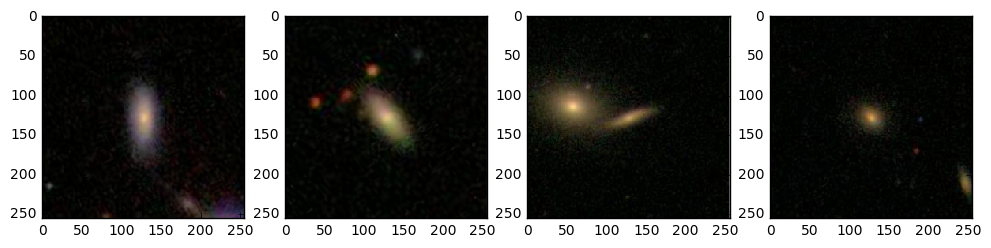

In [19]:
plots(imgs)

In [20]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [61]:
def galaxy():
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3,256,256)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(37)
        ])
    
    model.compile(Adam(lr=0.00001), loss='mse')
    return model

In [62]:
model = galaxy()

In [63]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=5, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/5
 2624/55420 [>.............................] - ETA: 994s - loss: 0.5725

KeyboardInterrupt: 

In [ ]:
test_batches = get_batches(test_path, batch_size=64, target_size=(256,256))

Found 79975 images belonging to 1 classes.


In [ ]:
test_files = test_batches.filenames
test_out = model.predict_generator(test_batches, test_batches.nb_sample)
save_array(path+'results/test_out.dat', test_out)

In [ ]:
features = list(df.columns.values)
test_ids = [os.path.splitext(f) for f in test_files]
submission = pd.DataFrame(test_out, columns=features[2:])
submission.insert(0, 'GalaxyID', [int(a[0][7:]) for a in test_ids])
submission.head()

In [ ]:
subm_name = 'subm.csv'
submission.to_csv('subm.csv', index=False)
FileLink(subm_name)